## Classification: Instant Recognition with Caffe

copy from caffe/examples/00-classification


### 0.prerequisites

#### python packages
* numpy
* matplotlib
* caffe
* yaml

### 1.setup

* setup python and packages

In [1]:
import print_helper
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* load caffe

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '/opt/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

!sudo chmod -R /opt/caffe/

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.
# ignore the warning

/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


* check

In [12]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    download_script = os.path.join(caffe_root,"scripts/download_model_binary.py")
    download_to = os.path.join(caffe_root,"models/bvlc_reference_caffenet")
    print(os.system(download_script+" "+download_to))
    # it will take time, just wait

CaffeNet found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

no description for deploy.prototxt, so I don't know what's the architecture for layers.

In [14]:
caffe.set_mode_gpu()
# caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's caffe.io.Transformer to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).
Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (outermost) dimension.
As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the innermost dimension, we are arranging for the needed transformations here.

In [17]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
print(net.blobs['data'].data.shape)

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
(10, 3, 227, 227)


### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [18]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

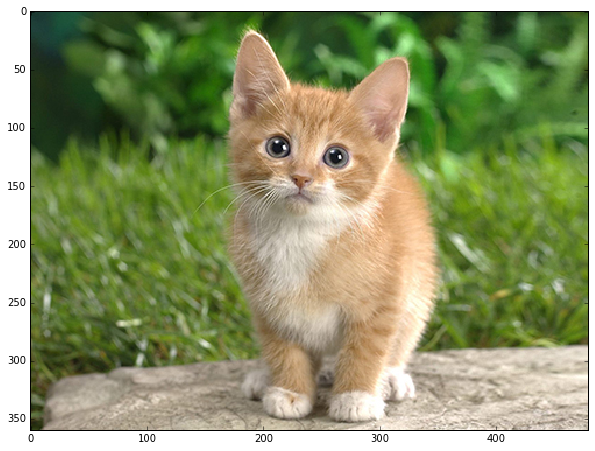

In [20]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

* Adorable! Let's classify it!

In [21]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 281


In [23]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

Downloading...
--2016-11-19 15:24:01--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: ‘caffe_ilsvrc12.tar.gz’

100%[======================================>] 17,858,008  2.13MB/s   in 8.0s   

2016-11-19 15:24:09 (2.14 MB/s) - ‘caffe_ilsvrc12.tar.gz’ saved [17858008/17858008]

Unzipping...
Done.
output label: n02123045 tabby, tabby cat


In [24]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.31243587, 'n02123045 tabby, tabby cat'),
 (0.23797128, 'n02123159 tiger cat'),
 (0.12387206, 'n02124075 Egyptian cat'),
 (0.10075714, 'n02119022 red fox, Vulpes vulpes'),
 (0.070956901, 'n02127052 lynx, catamount')]

* We see that less confident predictions are sensible.

### 4. Switching to GPU mode

* Let's see how long classification took, and compare it to GPU mode.

In [25]:
caffe.set_mode_cpu()
net.forward()  # run once before timing to set up memory
%timeit net.forward()

1 loop, best of 3: 1.54 s per loop


In [26]:
# caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 162 ms per loop


### 5. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [27]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [28]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


In [32]:
print dir(net)
# blobs, params, forward

['__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_backward', '_batch', '_blob_loss_weights', '_blob_names', '_blobs', '_blobs_dict', '_bottom_ids', '_forward', '_inputs', '_layer_names', '_output_list', '_outputs', '_params_dict', '_set_input_arrays', '_top_ids', 'backward', 'blob_loss_weights', 'blobs', 'bottom_names', 'copy_from', 'forward', 'forward_all', 'forward_backward_all', 'inputs', 'layers', 'outputs', 'params', 'reshape', 'save', 'set_input_arrays', 'share_with', 'top_names']


In [34]:
for name in net._layer_names:
    print "layer_name:", name

layer_name: data
layer_name: conv1
layer_name: relu1
layer_name: pool1
layer_name: norm1
layer_name: conv2
layer_name: relu2
layer_name: pool2
layer_name: norm2
layer_name: conv3
layer_name: relu3
layer_name: conv4
layer_name: relu4
layer_name: conv5
layer_name: relu5
layer_name: pool5
layer_name: fc6
layer_name: relu6
layer_name: drop6
layer_name: fc7
layer_name: relu7
layer_name: drop7
layer_name: fc8
layer_name: prob


In [35]:
for name in net._blob_names:
    print "blob_name:", name

blob_name: data
blob_name: conv1
blob_name: pool1
blob_name: norm1
blob_name: conv2
blob_name: pool2
blob_name: norm2
blob_name: conv3
blob_name: conv4
blob_name: conv5
blob_name: pool5
blob_name: fc6
blob_name: fc7
blob_name: fc8
blob_name: prob


* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [80]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    # see reshape_for_image
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    # this step is the core
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))

    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

    
    plt.imshow(data); 
    plt.axis('off')

* First we'll look at the first layer filters, conv1

net.params['conv1'][0] : <caffe._caffe.Blob object at 0x7f1c15ad65f0>
filters.shape : (96, 3, 11, 11)


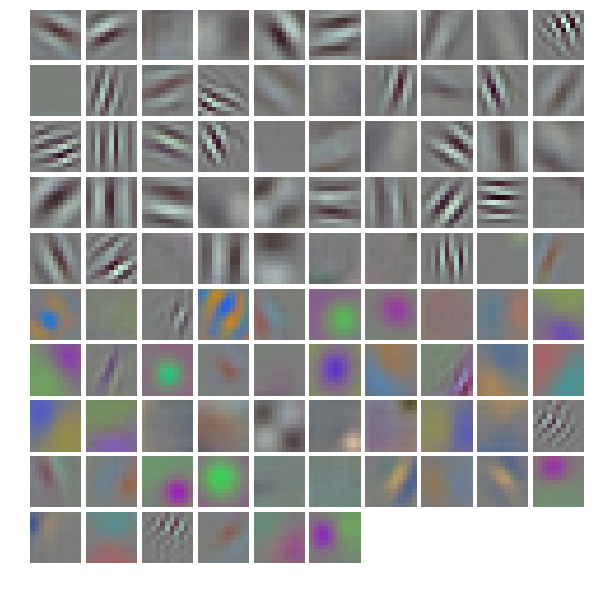

In [81]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data # net.params['conv1'][0] is the blob
np.save("conv1.data",filters)
net.params['conv1'][0].p()
filters.shape.p()
vis_square(filters.transpose(0, 2, 3, 1))

net.blobs['conv1'].data.shape : (50, 96, 55, 55)
feat.shape : (32, 55, 55)


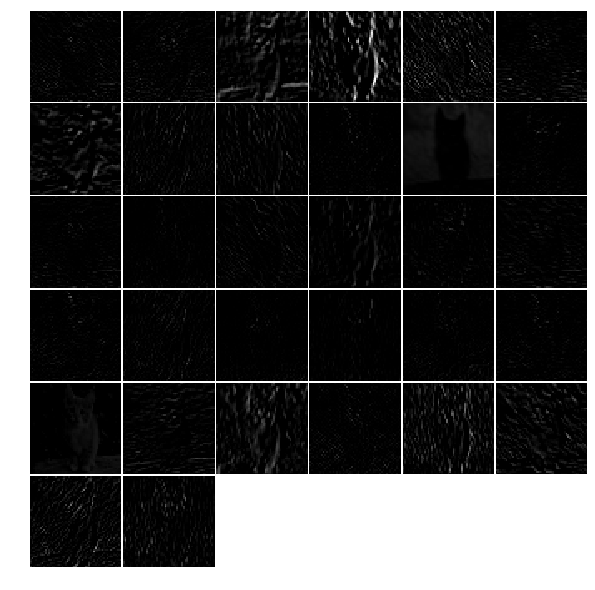

In [82]:
net.blobs['conv1'].data.shape.p()
feat = net.blobs['conv1'].data[0, :32]
feat.shape.p()
vis_square(feat)

* The fifth layer after pooling, `pool5`

feat.shape : (256, 6, 6)


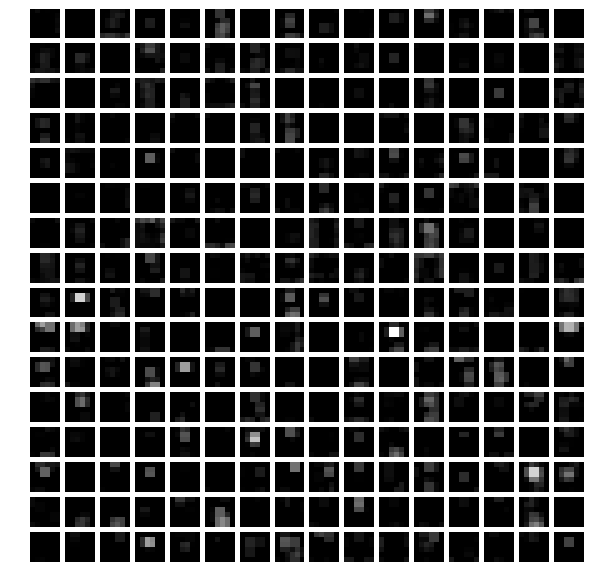

In [52]:
feat = net.blobs['pool5'].data[0]
feat.shape.p()
vis_square(feat)

* The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

feat.shape : (4096,)
feat.flat : <numpy.flatiter object at 0x1a838c10>


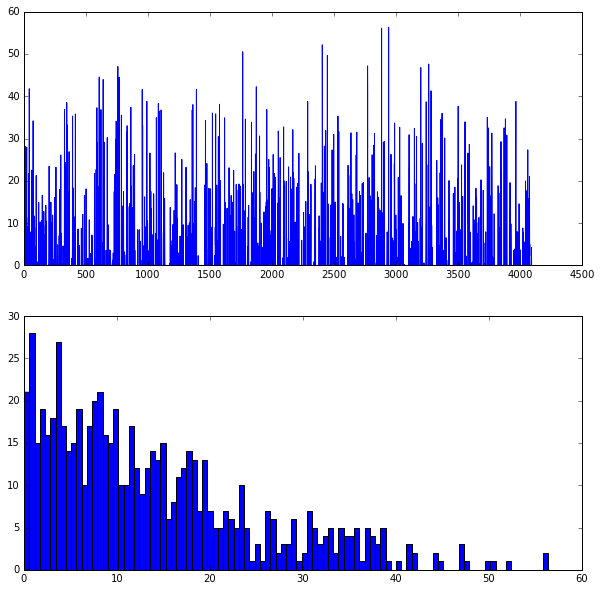

In [85]:
feat = net.blobs['fc6'].data[0]
feat.shape.p()
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
feat.flat.p()
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

* The final probability output, `prob`

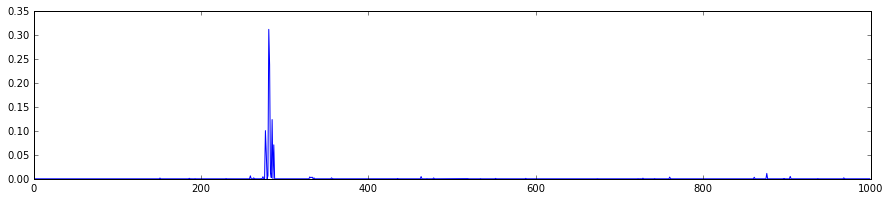

In [86]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

### 6. Try your own image
Now we'll grab an image from the web and classify it using the steps above.
Try setting my_image_url to any JPEG image URL.

probabilities and labels:


[(0.22499938, 'n07836838 chocolate sauce, chocolate syrup'),
 (0.14679633, 'n07892512 red wine'),
 (0.098842613, 'n07579787 plate'),
 (0.064830974, 'n03916031 perfume, essence'),
 (0.058154859, 'n07920052 espresso')]

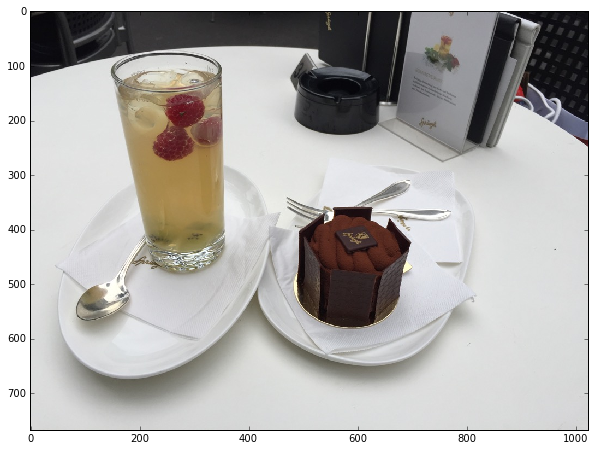

In [87]:
# download an image
#my_image_url = "..."  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
#!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('test.JPG')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])